## Zadání úlohy:
Po dráze se rovnoměrně přímočaře pohybuje vozíček. Každou sekundu je pomocí detektoru zaznamenána jeho poloha s přesností na 1 cm (musela jsem to trochu nastřelit, jinak by nebyly pořádně vidět errorbary).

Určete rychlost vozíčku.

(Okey tahle úloha je hoodně stupid, žádnej příčetnej člověk by to neměřil takhle)

### Import užitečných knihoven

In [522]:
import pandas as pd # načítání dat (also datové kontejnery, ale já mám radši numpy)
import numpy as np # matematické operace, lepší datové kontejnery, ...
from scipy import optimize # fitování
import matplotlib.pyplot as plt #grafy
import math # matematické operace a konstanty
from uncertainties import ufloat # práce s daty zatíženými chybou
from decimal import Decimal # zpoužijeme při zaokrouhlování na jednu platnou cifru

In [523]:
# Generování ukázkových dat - můžete ignorovat
np.random.seed(42)  # setup pro náhodné chyby
time = np.arange(50)  # [s]
true_speed = 4.2  # [cm/s]

error_factor = np.random.uniform(-0.25, 0.25, size=time.shape)
distance = true_speed * time + (true_speed * error_factor)

# Uložení dat do Excelu
pd.DataFrame({"t [s]": time, "s [cm]": distance}).to_excel("motivacni_uloha_1_data.xlsx", index=False)

### Pomocné funkce

In [ ]:
# =========================== FUNKCE PRO FITOVÁNÍ =====================================
def linear_fit(x:float, a:float, b:float)->float: 
    """Lineárni funkce y = a*x + b
    Args:
        x (int / float): bod vycislovani (namerena hodnota)
        a (int / float): koeficient
        b (int / float): konstanta
    Returns:
        float: hodnota linearni funkce s predpisem y = a*x + b v bode x
    """
    return a*x + b

# ======================== ZAOKROUHLOVANI NA JEDNU PLATNOU CIFRU =======================
def remove(n): # pomocna funkce pro round_to_reference - odstrani desetinnou část, pokud je n celé číslo
    if Decimal(n) == Decimal(n).to_integral():
        return int(n) 
    else: return n

def round_to_reference(x:float, y:float)->tuple[float, float]:
    """Zaokrouhleni vstupnich hodnot x a y na jednu platnou cifru podle y
    Args:
        x (float): hodnota k zaokrouhleni (namerena data)
        y (float): chyba mereni

    Returns:
        (float, float): hodnoty x a y zaokrouhlede na jednu platnou cifru podle y
    """
    pozice_platne_cifry = -int(np.floor(np.log10(y)))
    return remove(round(x, pozice_platne_cifry)), \
        remove(round(y, pozice_platne_cifry))

### Načítání dat

In [525]:
data = pd.read_excel("motivacni_uloha_1_data.xlsx")

presnost_draha = 1 # [cm], přesnost měření dráhy

cas = np.array(data["t [s]"]) # [s]
draha = np.array([ufloat(d, presnost_draha) for d in data["s [cm]"]])  # započítání chyby měření


### Získání rychlosti poprvé - pomocí výpočtu


In [526]:
rychlost = np.array([])
# počítáme rychlost v každém úseku mezi dvěma měřeními (pro fajnšmekry: tohle je v podstatě zpětná diference)
for i in range(len(draha)-1): 
    rychlost_v_useku = (draha[i+1] - draha[i]) / (cas[i+1] - cas[i])
    rychlost = np.append(rychlost, rychlost_v_useku)

# zaokrouhlení na jednu platnou cifru
prumerna_rychlost = round_to_reference(np.mean(rychlost).n, np.mean(rychlost).s) 
# .n a .s jsou atributy ufloat, n je hodnota, s je chyba

# výpis v LaTeX formátu
print(f"v=({prumerna_rychlost[0]}\\pm {prumerna_rychlost[1]})\\unit{{cm\\cdot s^{{-1}}}}")

v=(4.19\pm 0.03)\unit{cm\cdot s^{-1}}


#### Graf - histogram naměřených rychlostí

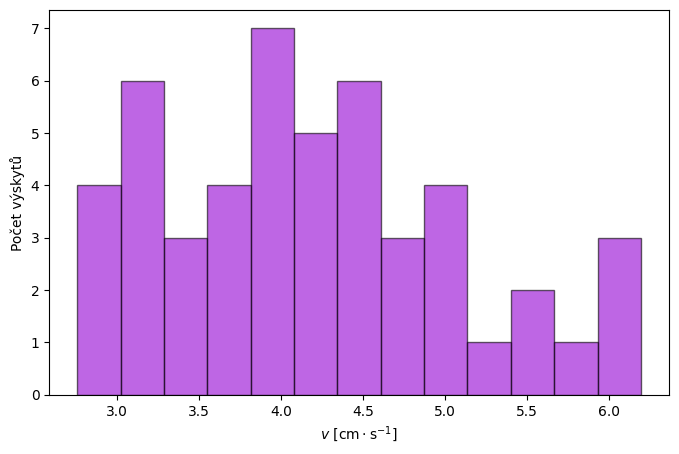

In [527]:
fig=plt.figure(figsize=(8,5))
plt.hist([v.n for v in rychlost], # data
         bins=13, # počet sloupců - je na vaší volbě
         color="darkviolet", edgecolor='black', alpha=0.6) # kosmetické úpravy (barva, okraje, průhlednost)
plt.xlabel('$v~\mathrm{[cm\cdot s^{-1}]}$')
plt.ylabel('Počet výskytů')
plt.show()
fig.savefig("motivacni_uloha_1_histogram.pdf")

### Získání rychlosti podruhé: fitování

In [ ]:
hodnoty_drahy = np.array([d.n for d in draha])
zaokrouhlene_drahy = []

# Fitování dat
params, covariance = optimize.curve_fit(linear_fit, cas, hodnoty_drahy)
errors = np.sqrt(np.diag(covariance))  # odhad chyb parametrů z diagonály kovarianční matice

# důvod proč volím optimize.curve_fit() namísto jiné funkce přímo pro lineární fit je ten,
# že optimize.curve_fit() je mnohem univerzálnější a lze jej použít pro jakoukoli jinou funkci
# např. polynom, exponenciálu, cosinus, atd. - je to na vás, jakou funkci si nadefinujete

for j in range(len(params)): # zaokrouhleni na jednu platnou cifru
    zaokrouhlene_drahy.append(round_to_reference(params[j], errors[j]))

# Výpis výsledků fitování v LaTeX formátu
print(f"Fit: $d=({zaokrouhlene_drahy[0][0]}\\pm {zaokrouhlene_drahy[0][1]})\\cdot t + ({zaokrouhlene_drahy[1][0]}\\pm {zaokrouhlene_drahy[1][1]})$".replace(".",","))

print(f"Rychlost vozíčku podle fitu je tedy $v=({zaokrouhlene_drahy[0][0]}\\pm {zaokrouhlene_drahy[0][1]})\\unit{{cm\\cdot s^{{-1}}}}$".replace(".",","))



Fit: $d=(4,197\pm 0,006)\cdot t + (-0,1\pm 0,2)$
Rychlost vozíčku podle fitu je tedy $v=(4,197\pm 0,006)\unit{cm\cdot s^{-1}}$


### Vykreslení grafu s naměřenými daty a fitovanou přímkou


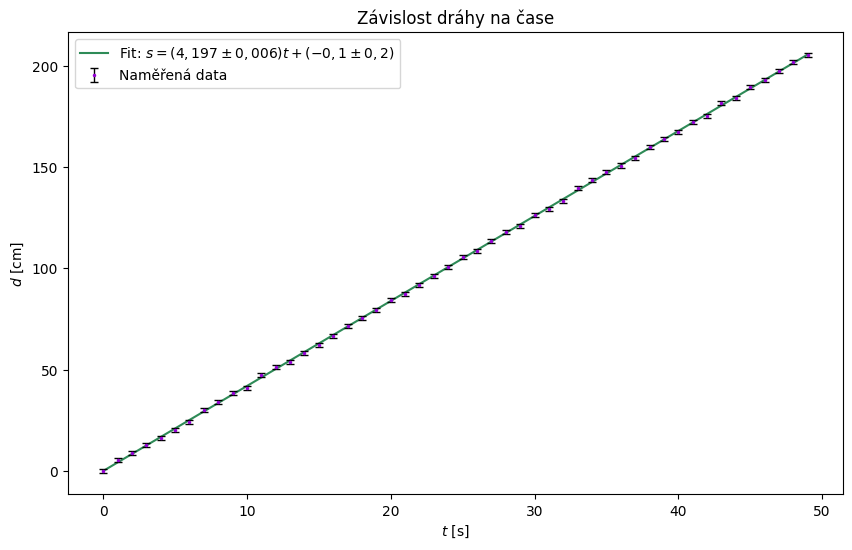

In [529]:
x_fit = np.linspace(0, max(cas), 100)
y_fit = linear_fit(x_fit, *params) 

fig=plt.figure(figsize=(10,6))
plt.plot(x_fit, y_fit, color="seagreen", label=f'Fit: $s=({zaokrouhlene_drahy[0][0]}\pm {zaokrouhlene_drahy[0][1]})t + ({zaokrouhlene_drahy[1][0]}\pm {zaokrouhlene_drahy[1][1]})$'.replace('.',','))
 
plt.errorbar(cas, hodnoty_drahy, yerr=presnost_draha, 
             color='darkviolet', ecolor='black', 
             fmt='.', ms=3, capsize=3, elinewidth=1, label='Naměřená data')
plt.xlabel('$t$ [s]')  
plt.ylabel('$d$ [cm]')
plt.title('Závislost dráhy na čase')
plt.legend()
plt.show()
fig.savefig("motivacni_uloha_1_graf.pdf")